In [1]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs

**PCA vs ICA**



In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

Download the data, if not already on disk and load it as numpy arrays

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Split into a training set and a test and keep 25% of the data for testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying PCA to extract the eigenfaces of the dataset

In [5]:
def _do_pca(n_components):
    t0 = time()
    pca = PCA(n_components=n_components, whiten=True).fit(X_train)
    n = pca.n_components_

    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, n

# Using SVM to classify the transformed data

In [6]:
def SVM_Classification(X_train, X_test):
    
    t0 = time()
    param_grid = {
        "C": loguniform(1e3, 1e5),
        "gamma": loguniform(1e-4, 1e-1),
    }
    clf = RandomizedSearchCV(
        SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
    )
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    return f1_score(y_test, y_pred,  average='weighted'), y_pred


**To get the best value of n_components, we use the explained variance from 0.90 to 0.99 for the PCA algorithm to automatically determine the n_components which result in that explained variance https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d**

# Using Different parameters for PCA

n: 74 Duration: 13.733 Accuracy: 87.51%
n: 82 Duration: 17.459 Accuracy: 85.89%
n: 92 Duration: 18.041 Accuracy: 85.11%
n: 104 Duration: 18.658 Accuracy: 85.14%
n: 119 Duration: 23.231 Accuracy: 85.37%
n: 138 Duration: 34.655 Accuracy: 86.13%
n: 162 Duration: 36.302 Accuracy: 85.70%
n: 195 Duration: 49.283 Accuracy: 85.40%
n: 246 Duration: 62.884 Accuracy: 84.49%


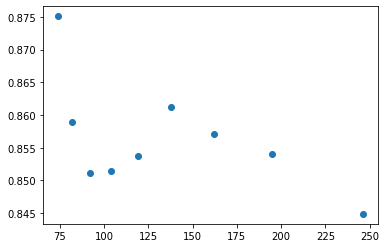

In [7]:
parameters = np.arange(0.90, 0.99, 0.01)
durations = []
results = []
components = []
for n_components in parameters:
    t0 = time()
    X_train_pca, X_test_pca, n = _do_pca(n_components)
    f1_weighted, _ = SVM_Classification(X_train_pca, X_test_pca)
    results.append(f1_weighted)
    components.append(n)
    elapsed = time() - t0
    durations.append(elapsed)
    print(f"n: {n} Duration: {elapsed:.3f} Accuracy: {f1_weighted:.2%}")

plt.scatter(components, results)
plt.xlabel = "Number of Components"
plt.ylabel = "Accuracy"
plt.show()

We get the number of principal components that give the highest accuracy in terms of f1-score

In [8]:
max_accuracy = np.argmax(results)
n_components = components[max_accuracy]
print(f"Best N Components Factor: {n_components}")
print(f"Accuracy (f1-score): {results[max_accuracy]:.2%}")

Best N Components Factor: 74
Accuracy (f1-score): 87.51%


The best n-component factor is 156 which gives an accuracy of 86.46%. The factor gives a 90% explanation of the variance in the training dataset, which retains most of the information needed for training the model without resulting in overfitting to the training dataset

In [9]:
X_train_pca, X_test_pca, n = _do_pca(n_components) 
_, y_pred = SVM_Classification(X_train_pca, X_test_pca)

# Qualitative evaluation of the predictions using matplotlib



In [10]:
def plot_gallery(images, h, w, n_row=3, n_col=4, titles=None, title=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    if title:
        plt.suptitle(title)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set



PREDICTION USING PCA


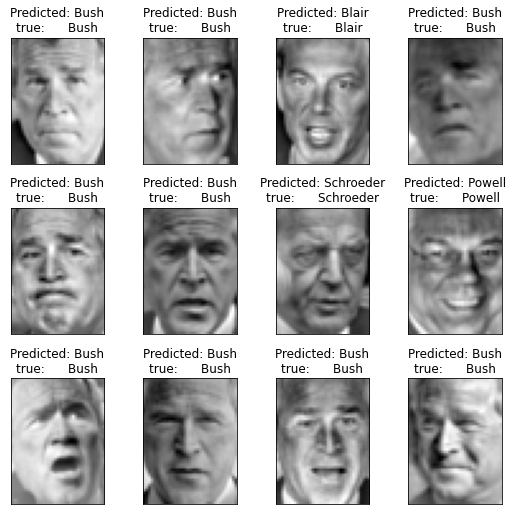

In [11]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "Predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

print("PREDICTION USING PCA")

plot_gallery(X_test, h, w, titles=prediction_titles)

# plot the gallery of the most significative eigenfaces



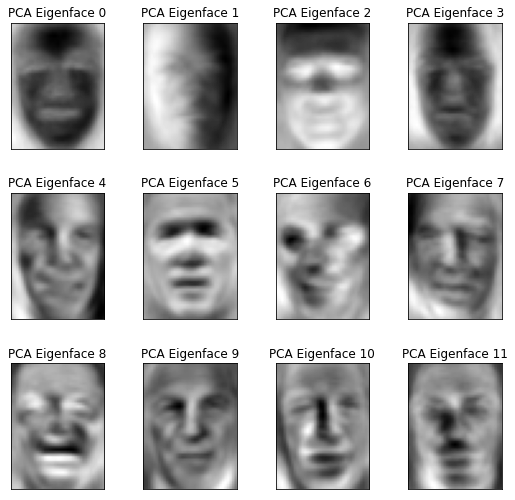

In [12]:
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))

eigenface_titles = ["PCA Eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, h, w, titles=eigenface_titles)

plt.show()

# Defining a function for using ICA

In [13]:
def do_ica(n_components, max_iter=400):
    t0 = time()
    ica_estimator = FastICA(
        n_components=n_components, max_iter=max_iter, whiten="arbitrary-variance", tol=15e-5
    )
    n = ica_estimator.n_components
    ica_estimator.fit(X_train)

    t0 = time()
    X_train_ica = ica_estimator.transform(X_train)
    X_test_ica = ica_estimator.transform(X_test)
    return X_train_ica, X_test_ica, n

# Using different parameters for ICA

n: 74 Duration: 14.421 Accuracy: 82.56%
n: 82 Duration: 15.763 Accuracy: 82.95%
n: 92 Duration: 16.434 Accuracy: 81.79%
n: 104 Duration: 20.195 Accuracy: 83.31%
n: 119 Duration: 25.683 Accuracy: 85.24%
n: 138 Duration: 32.032 Accuracy: 84.44%
n: 162 Duration: 31.145 Accuracy: 82.27%
n: 195 Duration: 41.281 Accuracy: 81.82%
n: 246 Duration: 63.107 Accuracy: 81.44%


<function matplotlib.pyplot.show(close=None, block=None)>

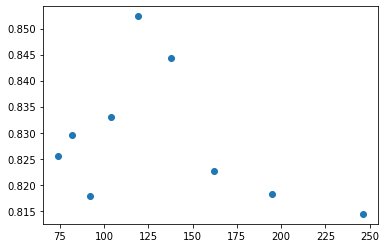

In [14]:
durations = []
results = []
for n_components in components:
    t0 = time()
    X_train_ica, X_test_ica, n = do_ica(n_components)
    f1_weighted, elapsed = SVM_Classification(X_train_ica, X_test_ica)
    results.append(f1_weighted)
    durations.append(elapsed)
    elapsed = time() - t0
    print(f"n: {n} Duration: {elapsed:.3f} Accuracy: {f1_weighted:.2%}")

plt.scatter(components, results)
plt.xlabel = "Number of components"
plt.ylabel = "Accuracy"
plt.show

In [15]:
max_accuracy = np.argmax(results)
n_components = components[max_accuracy]
print(f"Best N Components Factor: {n_components}")
print(f"Accuracy (f1-score): {results[max_accuracy]:.2%}")

Best N Components Factor: 119
Accuracy (f1-score): 85.24%


In [16]:
durations = []
results = []
_iterations = range(200, 401, 50)
for iters in _iterations:
    t0 = time()
    X_train_ica, X_test_ica, n = do_ica(n_components, max_iter=iters)
    f1_weighted, elapsed = SVM_Classification(X_train_ica, X_test_ica)
    results.append(f1_weighted)
    durations.append(elapsed)
    elapsed = time() - t0
    print("Done in %0.3fs" % (elapsed))
    print(f1_weighted)




Done in 25.470s
0.8178817264899608
Done in 24.742s
0.821589664643087
Done in 21.528s
0.830450771678732
Done in 22.813s
0.8239695481997835
Done in 24.008s
0.8553195915270422


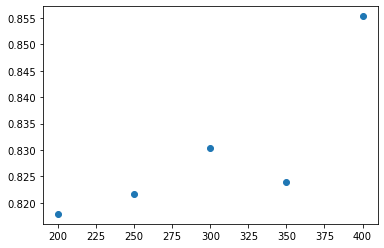

In [17]:
plt.scatter(_iterations, results)

plt.xlabel = "Number of iterations"
plt.ylabel = "Accuracy"
plt.show()


In [18]:
max_accuracy = np.argmax(results)
iter = _iterations[max_accuracy]
print(f"Best Max Iteration: {iter}")
print(f"Accuracy (f1-score): {results[max_accuracy]:.2%}")

Best Max Iteration: 400
Accuracy (f1-score): 85.53%


**The most accurate model uses 200 iterations which is enough for the model to converge but do not result in overtraining**

# Using SVM to classify data for ICA

In [19]:
X_train_ica, X_test_ica, n = do_ica(n_components, iter) 
_, y_pred =SVM_Classification(X_train_ica, X_test_ica)

Prediction Using ICA



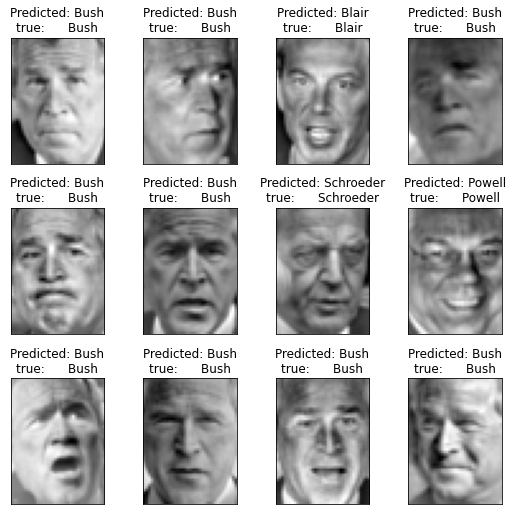

In [20]:
print("Prediction Using ICA\n")
plot_gallery(X_test, h, w, titles=prediction_titles)

# Plot most Significant ICA Eigenfaces

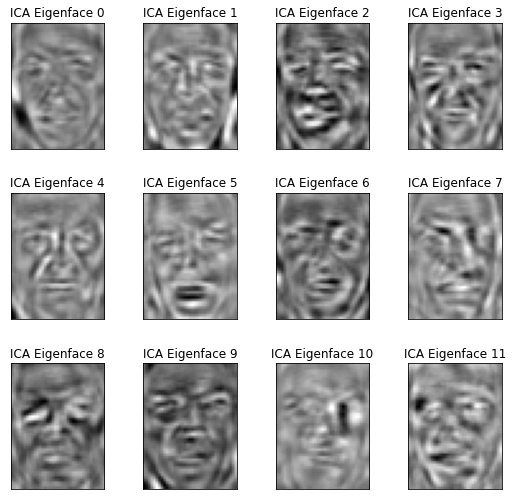

In [21]:
ica_estimator = FastICA(
        n_components=n_components, max_iter=iter, whiten="arbitrary-variance", tol=15e-5
    )

ica_estimator.fit(X_train)
components = ica_estimator.components_[:n_components]
eigenface_titles = [f"ICA Eigenface {i}"  for i in range(components.shape[0])]
plot_gallery(components, h, w, titles=eigenface_titles)

plt.show()